# Google Landmark 2019

References:
4th place solution last year
https://www.kaggle.com/c/landmark-recognition-challenge/discussion/57896#latest-418704

Compressed and resized training and test images
https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770#latest-532165

https://www.kaggle.com/c/landmark-recognition-2019/discussion/90346#latest-532193

EDA and loading data
https://www.kaggle.com/mayukh18/dataset-exploration-and-simple-on-the-fly-training



Plan

1. bring in training images that have >K examples for each class.  K=10
2. Train resnet34 on this and see xval score (basic classification)
3. Understand how to measure the metric being optimized in the contest
4. develop a heuristic/trained approach for submitting results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 200
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [4]:
path=Path("/media/SSD/data_google_landmark_recog_2019")
path.ls()

[PosixPath('/media/SSD/data_google_landmark_recog_2019/recognition_sample_submission.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256.tar'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/data_import.sh'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256.zip')]

In [5]:
path_img = path / 'train-256'
path_img

PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256')

## Looking at the data

In [6]:
train = pd.read_csv(path / "train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))


                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [7]:
files = os.listdir(path_img)

In [8]:
#file_jpg = [k for k in files if '.jpg' in k]

In [9]:

#file_dict = {clean_string(x) : x for x in files if '.jpg' in x}


In [8]:
#get all the files in the image directory and drop the ''.jpg' of the filename to get the 'id' of the image
def clean_string (x):
    return x[:-4]

#lst = set(map(clean_string,os.listdir(path_img)))
lst = set([clean_string(x) for x in files if '.jpg' in x])

In [9]:
# select image ids that have image files
lst3 = [value[0] for value in zip(train.index, train['id']) if value[1] in lst]
train2=train.loc[lst3]

In [10]:
K=100
counts = dict(Counter(train2['landmark_id']))
landmarks_dict = {x:[] for x in train2.landmark_id.unique() if (counts[x] >= K)}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 6513


In [11]:
new_train = train2[train2['landmark_id'].isin(landmarks_dict)].copy()
print(new_train.head())
print(new_train.shape)
print("Number of classes {}".format(len(new_train.landmark_id.unique())))

                  id                                                url  \
1   202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
4   4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   
6   6f31b874d1a4d489  https://upload.wikimedia.org/wikipedia/commons...   
9   8df019949b8db328  https://upload.wikimedia.org/wikipedia/commons...   
11  ccf070a2da242d56  https://upload.wikimedia.org/wikipedia/commons...   

    landmark_id  
1        104169  
4          2474  
6          6888  
9         81049  
11       138982  
(1263760, 3)
Number of classes 6513


In [14]:
from PIL import Image
im = Image.open(path_img/"7e0fedbe3830f841.jpg")
im.show()

In [20]:
str(new_train[new_train['id']=="753fee7858e93a2b"].url)

'103968    https://upload.wikimedia.org/wikipedia/commons...\nName: url, dtype: object'

In [23]:
'753fee7858e93a2b' in lst

True

In [24]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train2', 1027533436),
 ('train', 995108946),
 ('lst', 134217952),
 ('new_train', 69702664),
 ('files', 35746776),
 ('lst3', 35746776),
 ('counts', 10485864),
 ('landmarks_dict', 18528),
 ('fastai_types', 2280),
 ('Series', 1184),
 ('TfmAffine', 1184),
 ('TfmCoord', 1184),
 ('TfmCrop', 1184),
 ('TfmLighting', 1184),
 ('AUROC', 1056),
 ('AccumulateScheduler', 1056),
 ('AdaptiveConcatPool2d', 1056),
 ('AffineMatrix', 1056),
 ('AverageMetric', 1056),
 ('BatchNorm1dFlat', 1056),
 ('BatchSampler', 1056),
 ('BnFreeze', 1056),
 ('Callback', 1056),
 ('CallbackHandler', 1056),
 ('Category', 1056),
 ('CategoryList', 1056),
 ('CategoryProcessor', 1056),
 ('ClassificationInterpretation', 1056),
 ('Config', 1056),
 ('ConfusionMatrix', 1056),
 ('Counter', 1056),
 ('DataBunch', 1056),
 ('DataFrame', 1056),
 ('DataLoader', 1056),
 ('Dataset', 1056),
 ('DatasetType', 1056),
 ('Debugger', 1056),
 ('DeviceDataLoader', 1056),
 ('DistributedDataParallel', 1056),
 ('EmptyLabel', 1056),
 ('EmptyLabelList',

In [20]:
#move the images to the SSD resized
pathd = Path("/home/filip/google landmark 2019/train")
path_hr = pathd/'images'
path_lr = pathd/'small-96'
path_mr = pathd/'small-256'

il = ImageList.from_df(path=path_img, df=new_train, cols="id", suffix='.jpg')
#il = ImageList.from_folder(path_hr)

def resize_one(fn, i, path, size):
    dest = pathd/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(path_img / fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=90)

# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /home/filip/google landmark 2019/train/small-96


AttributeError: 'numpy.str_' object has no attribute 'relative_to'

In [30]:
pathd = path
path_hr = path_img
path_lr = pathd/'small-224'
path_mr = pathd/'small-256'


il = ImageList.from_folder(path_hr)

def resize_one(fn, i, path, size):
    dest = pathd/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=90)

# create smaller image sets the first time this nb is run
sets = [(path_lr, 224), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 224 into /media/filip/New Volume/data_google_landmark_recog_2019/small-224


AttributeError: 'numpy.str_' object has no attribute 'relative_to'

In [28]:
fn=Path("7e0fedbe3830f841.jpg")
pathd/fn.relative_to(path_hr)

ValueError: '7e0fedbe3830f841.jpg' does not start with '/media/filip/New Volume/data_google_landmark_recog_2019/train-256/train'

In [12]:
del train2,train, lst, files, lst3, counts, landmarks_dict

In [13]:
learn=None
gc.collect()
torch.cuda.empty_cache()

In [14]:
#data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs, num_workers=5).normalize(imagenet_stats)


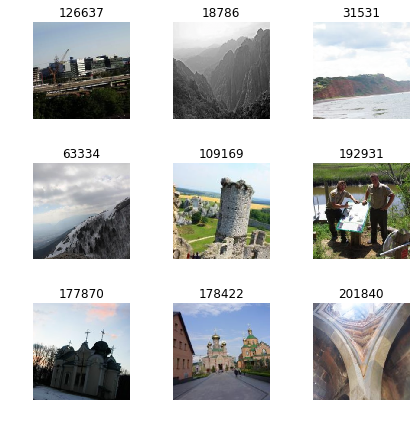

In [29]:
data.show_batch(rows=3, figsize=(6,6))

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

In [ ]:
def GAP_vector(pred, conf, true, return_x=False):
    '''
    Compute Global Average Precision (aka micro AP), the metric for the
    Google Landmark Recognition competition. 
    This function takes predictions, labels and confidence scores as vectors.
    In both predictions and ground-truth, use None/np.nan for "no label".

    Args:
        pred: vector of integer-coded predictions
        conf: vector of probability or confidence scores for pred
        true: vector of integer-coded labels for ground truth
        return_x: also return the data frame used in the calculation

    Returns:
        GAP score
    '''
    x = pd.DataFrame({'pred': pred, 'conf': conf, 'true': true})
    x.sort_values('conf', ascending=False, inplace=True, na_position='last')
    x['correct'] = (x.true == x.pred).astype(int)
    x['prec_k'] = x.correct.cumsum() / (np.arange(len(x)) + 1)
    x['term'] = x.prec_k * x.correct
    gap = x.term.sum() / x.true.count()
    if return_x:
        return gap, x
    else:
        return gap

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [17]:
learn.freeze()
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,6.396007,5.760169,0.852781,37:18
1,5.852680,5.126049,0.792239,37:03
2,5.695752,4.881757,0.760496,37:02
3,5.589668,4.705878,0.739523,37:15
4,5.502891,4.589825,0.724180,36:53
5,5.427714,4.492505,0.710281,37:01
6,5.287908,4.381384,0.694677,37:17
7,5.155597,4.260483,0.677154,37:27
8,4.978669,4.175903,0.660224,37:20
9,4.874754,4.146789,0.655615,36:43


In [21]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

RuntimeError: expected scalar type Half but found Float

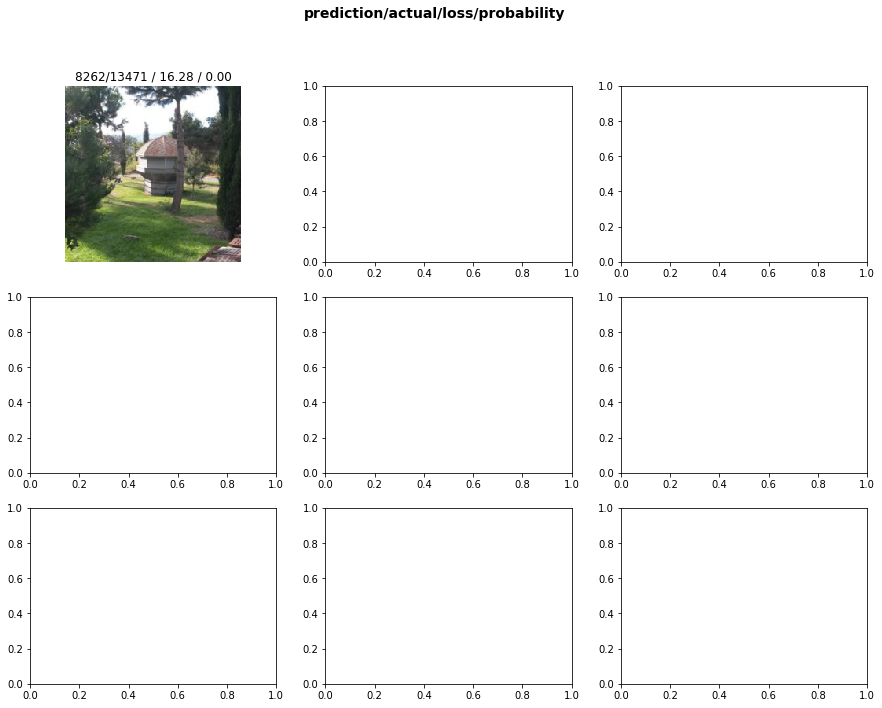

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

KeyboardInterrupt: 

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [18]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.load('stage-1');

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.00E-05


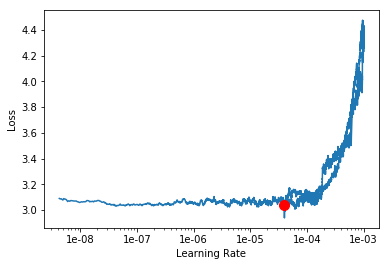

In [29]:
learn.recorder.plot(suggestion=True)

In [24]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,4.756652,4.020216,0.641194,41:40
1,4.652628,3.880990,0.629142,41:44
2,4.644060,3.843672,0.634962,41:39
3,4.794571,3.887444,0.649289,41:50
4,4.759430,3.910679,0.652264,41:28
5,4.634813,3.774528,0.637055,41:32
6,4.411050,3.646343,0.617024,41:32
7,4.340672,3.542324,0.603528,41:40
8,4.217664,3.459237,0.591358,41:52
9,4.070976,3.369003,0.577222,41:33


In [25]:
learn.save('stage-2')

In [26]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,4.124119,3.437955,0.586555,41:27
1,4.189321,3.421077,0.584158,41:24
2,3.770590,3.154281,0.545274,41:24
3,3.330736,2.907965,0.500736,41:36
4,3.093586,2.830433,0.483688,41:37


In [27]:
learn.save('stage-3')

In [30]:
learn.fit(2, lr=slice(1e-5,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,2.961560,2.831459,0.483814,41:34
1,2.972573,2.824378,0.480760,41:24


In [31]:
learn.save('stage-4')

# Predict test set

In [32]:
#export model and other contains everything we need to deploy our model 
#(the model, the weights but also some metadata like the classes or the transforms/normalization used).
learn.export()

#to load it
#learn = load_learner(path)


In [36]:
# path to test set
path_test = path / 'test-256/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256/test')

In [52]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [53]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

,landmarks
id,
b8a5057fdc51fb0a,115821 0.023227360099554062
a0ae5b40187f3e6e,60532 0.4344411790370941
8102cf887daa75b9,136302 0.023837383836507797
4ecb95f6b5bb1388,131452 0.10918108373880386
957bbc9b29ad7e6f,46775 0.9098647236824036
21708d4a4d8c931c,57505 0.05510774627327919
d2c100037c1d86e6,64042 0.46230411529541016
a584a76ac65d7fe7,126637 0.12927401065826416
df538ae06673150c,47207 0.021939314901828766


In [55]:
submission.to_csv(path / 'submission1.csv',index=True)

https://www.kaggle.com/c/landmark-recognition-2019/discussion/89903#latest-530343

Hello everyone,
in train data Landmark with Id = 138982 has 10247 images. I looked at some of them and found that they are from rather different places.
So i think that images with this Landmark_Id are not associated with any real landmark. 

In [57]:
#blank out the results to indicate no mandmarl for this id
submission.loc[submission['landmarks'].str.contains('138982 '), 'landmarks'] = ""

In [58]:
submission.to_csv(path / 'submission1.1.csv',index=True)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes